In [1]:
# import rozneho potrebneho...

%load_ext autoreload
%autoreload

%matplotlib nbagg

import numpy as np
from scipy.integrate import odeint

import sys
sys.path.append('./misc/')

from figFcns_nb import *

# Doplnenie algoritmu RMNŠ do simulačnej schémy

V predchádzajúcom bola vytvorená simulačná schéma pre simuláciu uvažovaného riadeného systému.

Tu je cieľom doplniť do simulačnej schémy algoritmus RMNŠ.

Pre úplnosť, ARX (AutoRegressive eXogenous) model, ktorý je identifikovaný (klasickou RMNŠ), je vo všeobecnosti nasledovný:
$$
	A(z^{-1})y(k) = B(z^{-1})u(k) + \xi(k)
$$
kde
$$
	\begin{split}
		 B(z^{-1}) &= b_1z^{-1} + \ldots + b_{n_b}z^{-n_b} \\
		 A(z^{-1}) &= 1 + a_1z^{-1} + \ldots + a_{n_a}z^{-n_a}
	\end{split}
$$
a $\xi(k)$ predstavuje poruchy a šum. V ďalšom budeme uvažovať $\xi(k) = 0$. ARX model vyjadrený v tvare diferenčnej rovnice:
$$
	\begin{split}
		y(k) = & -a_1y(k-1) - \ldots - a_{n_a}y(k-n_a) +  b_1u(k-1) + \ldots + b_{n_b}u(k-n_b)
	\end{split}
$$

Nech modelom riadeného systému je diferenčná rovnica v uvedenom tvare, kde hodnoty $n_a = 2$ a $n_b = 2$. Potom táto diferenčná rovnica má tvar
$$
	y(k) =  - a_1y(k-1) - a_2y(k-2) + b_1u(k-1) + b_2u(k-2)
$$
V maticovom zápise:
$$
	y(k) = h^\mathsf T \Theta
$$
kde $h^\mathsf T = \begin{bmatrix} -y(k-1) & -y(k-2) & u(k-1) & u(k-2) \end{bmatrix}$  a $\Theta = \begin{bmatrix} a_1 & a_2 & b_1 & b_2 \end{bmatrix}^\mathsf T$.
Neznámymi parametrami modelu teda sú koeficienty $a_1$, $a_2$, $b_1$ a $b_2$.

Funkcia, ktorá realizuje diferenciálne rovnice riadeného systému imporotovaná tu:

In [2]:
import plantFcns

Simulačnú schému nech realizuje nasledujúca funkcia:

In [3]:
def fcn_simSch_02_lenRMNS(t_start, T_s, finalIndex, sig_u_ext):

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_0 = np.array([0, 0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    #-----------------------------------------

    u_log = np.zeros([finalIndex, 1])

    #-----------------------------------------

    RMNS_theta_0 = np.array([[ 0.001],
                             [ 0.001],
                             [ 0.001],
                             [ 0.001]])


    RMNS_theta_log = np.zeros([finalIndex, len(RMNS_theta_0)])
    RMNS_theta_log[0,:] = RMNS_theta_0.reshape(1,-1)

    RMNS_P_0 = np.identity(4) * 10**6

    RMNS_P_log = np.zeros([finalIndex, RMNS_P_0.size])
    RMNS_P_log[0,:] = RMNS_P_0.reshape(1,-1)

    RMNS_y_predict_log = np.zeros([finalIndex, 1])

    #-----------------------------------------



    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        odeOut = odeint(plantFcns.fcn_difRovnice,
                        x_log[idx-1,:],
                        timespan,
                        args=(u_log[idx-1,:],)
                        )

        x_log[idx,:] = odeOut[-1,:]
        t_log[idx,:] = timespan[-1]


        #--------------------
        # ALGORITMUS RMNS
        y_k = x_log[idx,0]

        h_k = np.array([[-x_log[idx-1,0]],
                        [-x_log[idx-2,0]],
                        [u_log[idx-1,0]],
                        [u_log[idx-2,0]],
                        ])

        theta_km1 = RMNS_theta_log[idx-1,:].reshape(4,-1)
        P_km1 = RMNS_P_log[idx-1,:].reshape(4,4)

        #----------
        e_k = y_k - np.matmul(h_k.T, theta_km1)

        lambdaKoef = 1.0

        Y_k =  np.matmul(P_km1, h_k) / (lambdaKoef + np.matmul(np.matmul(h_k.T, P_km1), h_k))

        P_k = (1/lambdaKoef) * (P_km1 - np.matmul(np.matmul(Y_k, h_k.T), P_km1))
        theta_k = theta_km1 + Y_k * e_k

        #----------
        RMNS_theta_log[idx,:] = theta_k.reshape(1,-1)
        RMNS_P_log[idx,:] = P_k.reshape(1,-1)

        RMNS_y_predict_log[idx,:] = np.matmul(h_k.T, theta_km1)

        #--------------------
        u_log[idx,:] = sig_u_ext[idx-1,:]



    return [t_log, x_log, RMNS_y_predict_log, RMNS_theta_log]

V uvedenej simulačnej schéme je implementovaný RMNŠ algoritmus, ktorého výstupom je vektor parametrov ```theta_k``` a následne je tiež vypočítaná (v každom cykle) jednokroková predikcia výstupného signálu zapisovaná do vektora ```RMNS_y_predict_log```.

Všimnime si tiež napríklad, že faktor zabúdania $\lambda$ (premenná ```lambdaKoef```) je nastavený na hodnotu $\lambda = 1$, teda algoritmus nevyužíva zabúdanie.

Nastavenia potrebné pre samotnú simuláciu a vygenerovanie signálov, ktoré sa používajú pri simulácii (ktoré sú dopredu známe - dané):

In [4]:
# Nastavenia simulacie

sim_t_start = 0
sim_t_final = 35
sim_T_s = 0.25
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)

Pre simuláciu je potrebné vytvoriť vstupný signál $u(t)$ pre riadený systém. Nech je nasledovný:

In [5]:
period_time = 40
period_tab = np.array([
                      [0, 1],
                      [10, 0],
                      [20, -1],
                      [30, 0],
                      ])

sig_vysl = np.zeros([sim_finalIndex, 1])

for period in range(int(sim_t_final/period_time) + 1):


    for idx in range( int((period*period_time)/sim_T_s), int((period*period_time + period_time)/sim_T_s)):

        lastValue = period_tab[:,1][(period_tab[:,0] + (period*period_time))<=idx*sim_T_s ][-1]
        try:
            sig_vysl[idx] = lastValue
        except:
            break


sig_u_ext = sig_vysl

Spustenie simulácie:

In [6]:
# Spustenie simulacie

t_log, x_log, RMNS_y_predict_log, RMNS_theta_log = fcn_simSch_02_lenRMNS(
    sim_t_start,
    sim_T_s,
    sim_finalIndex,
    sig_u_ext,
    )

Nakreslenie obrázku (pre prehľadnosť tohto notebooku je kód v samostatnom súbore):

<IPython.core.display.Javascript object>


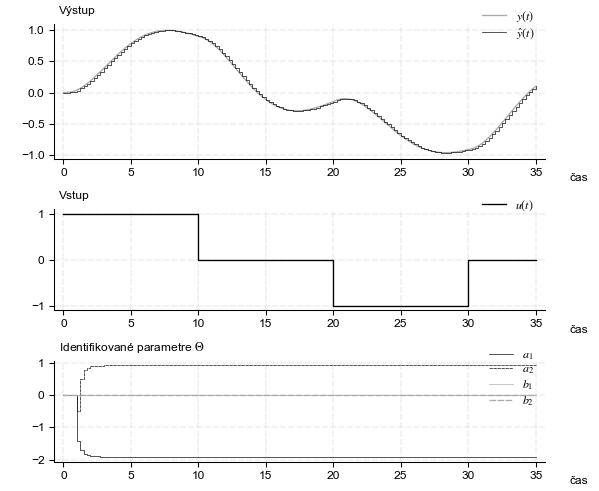

In [7]:
execfile('misc/v_fig_lenRMNS.py')

Pre zaujímavosť, priebežne identifikované parametre $\Theta$ sú zapisované do poľa ```RMNS_theta_log```. Posledný riadok v tomto poli je:

In [8]:
print RMNS_theta_log[-1,:]

[-1.91568503  0.92771664  0.00456797  0.00445615]
